# MCMC Walkthrough

This notebook contains examples of how to use the MCMC Fitter class and how to modify it for more specific uses.

All of these examples will use the EmceeSampler class, which is currently the only Sampler implementation supported by PINT. Future work may include implementations of other sampling methods.

In [1]:
import numpy as np
import pint.models
import pint.toa as toa
import pint.fermi_toas as fermi
from pint.residuals import Residuals
from pint.sampler import EmceeSampler
from pint.mcmc_fitter import MCMCFitter, MCMCFitterBinnedTemplate
from pint.scripts.event_optimize import read_gaussfitfile, marginalize_over_phase
from astropy import log
import matplotlib.pyplot as plt
import pickle

In [2]:
log.setLevel('WARNING')

In [3]:
np.random.seed(1)

## Basic Example

This example will show a vanilla, unmodified MCMCFitter operating with a simple template and on a small dataset. The sampler is a wrapper around the *emcee* package, so it requires a number of walkers for the ensemble sampler. This number of walkers must be specified by the user.

The first few lines are the basic methods used to load in models, TOAs, and templates. More detailed information on this can be found in *pint.scripts.event_optimize.py*.

In [4]:
parfile = 'PSRJ0030+0451_psrcat.par'
eventfile = 'J0030+0451_P8_15.0deg_239557517_458611204_ft1weights_GEO_wt.gt.0.4.fits'
gaussianfile = 'templateJ0030.3gauss'
weightcol='PSRJ0030+0451'

In [5]:
minWeight = 0.9
nwalkers = 10
nsteps = 50
nbins = 256
phs = 0.0

In [6]:
model = pint.models.get_model(parfile)
tl = fermi.load_Fermi_TOAs(eventfile, weightcolumn=weightcol,
                          minweight=minWeight)
ts = toa.TOAs(toalist=tl)
#Introduce a small error so that residuals can be calculated
ts.table['error'] = 1.0
ts.filename = eventfile
ts.compute_TDBs()
ts.compute_posvels(ephem='DE421', planets=False)

In [7]:
weights = np.asarray([x['weight'] for x in ts.table['flags']])
template = read_gaussfitfile(gaussianfile, nbins)
template /= template.mean()

### Sampler and Fitter creation

The sampler must be initialized first, and then passed as an argument into the *MCMCFitter* constructor. The fitter will send its log-posterior probabilility function to the sampler for the MCMC run. The log-prior and log-likelihood functions of the *MCMCFitter* can be written by the user. The default behavior is to use the functions implemented in the *pint.mcmc_fitter* module.

The *EmceeSampler* requires only an argument for the number of walkers in the ensemble.

Here, we use *MCMCFitterBinnedTemplate* because the Gaussian template not a callable function. If the template is analytic and callable, then *MCMCFitterAnalyticTemplate* should be used, and template parameters can be used in the optimization.

In [8]:
sampler = EmceeSampler(nwalkers)

In [9]:
fitter = MCMCFitterBinnedTemplate(ts, model, sampler, template=template,
                                  weights=weights, phs=phs)

The next step determines the predicted starting phase of the pulse, which is used to set an accurate initial phase in the model. This will result in a more accurate fit. This step uses the *marginalize over phase* method implemented in *pint.scripts.event_optimize.py*.

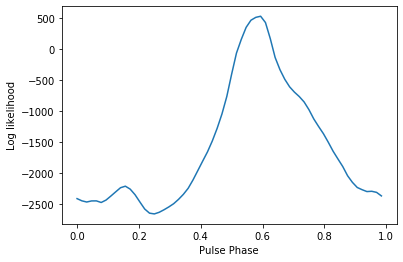

Starting pulse likelihood: 539.544371
Starting pulse phase: 0.589484
Pre-MCMC Values:
      F0:	      205.53
      F1:	 -4.2976e-16
   PHASE:	     0.58948


In [10]:
phases = fitter.get_event_phases()
maxbin, like_start = marginalize_over_phase(phases, template, 
                                            weights=fitter.weights,
                                            minimize=True,
                                            showplot=True)
fitter.fitvals[-1] = 1.0 - maxbin[0] / float(len(template))
print('Starting pulse likelihood: %f' % like_start)
print('Starting pulse phase: %f' % fitter.fitvals[-1])
print('Pre-MCMC Values:')
for name, val in zip(fitter.fitkeys, fitter.fitvals):
    print('%8s:\t%12.5g' % (name, val))

The MCMCFitter class is a subclass of *pint.fitter.Fitter*. It is run in exactly the same way - with the *fit_toas()* method.

In [11]:
fitter.fit_toas(maxiter=nsteps, pos=None)
fitter.set_parameters(fitter.maxpost_fitvals)

To make this run relatively fast for demonstration purposes, nsteps was purposefully kept very small. However, this means that the results of this fit will not be very good. For an example of MCMC fitting that produces better results, look at pint/examples/fitNGC440E_MCMC.py

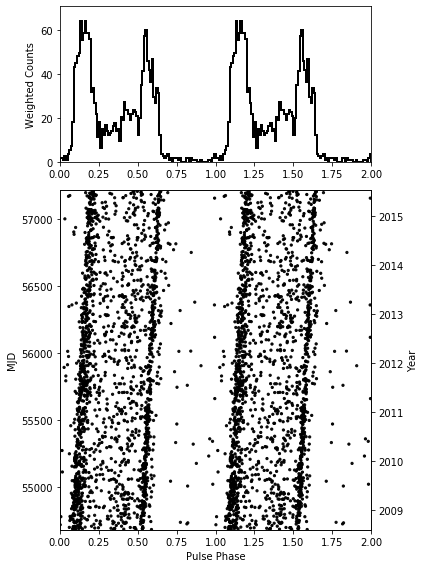

Post-MCMC values (50th percentile +/- (16th/84th percentile):
      F0:         205.530699272645 (+   1.7391e-08  / -   8.7218e-09)
      F1:              -4.2976e-16 (+   1.4621e-19  / -    1.272e-19)
   PHASE:        0.589411744786337 (+   0.00098982  / -    0.0027007)
Final ln-posterior:       640.25


In [12]:
fitter.phaseogram()
samples = sampler.sampler.chain[:, 10:, :].reshape((-1, fitter.n_fit_params))
ranges = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
             zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("Post-MCMC values (50th percentile +/- (16th/84th percentile):")
for name, vals in zip(fitter.fitkeys, ranges):
    print("%8s:"%name + "%25.15g (+ %12.5g  / - %12.5g)"%vals)
print("Final ln-posterior: %12.5g" % fitter.lnposterior(fitter.maxpost_fitvals))

## Customizable Example

This second example will demonstrate how the *MCMCFitter* can be customized  for more involved use. Users can define their own prior and likelihood probability functions to allow for more unique configurations.

In [13]:
timfile2 = 'NGC6440E.tim'
parfile2 = 'NGC6440E.par.good'
model2 = pint.models.get_model(parfile2)
toas2 = toa.get_TOAs(timfile2, planets=False, ephem='DE421')
nwalkers2 = 12
nsteps2 = 10

The new probability functions must be defined by the user and must have the following characteristics. They must take two arguments: an *MCMCFitter* object, and a vector of fitting parameters (called *theta* here). They must return a float (not an astropy Quantity). 

The new functions can be passed to the constructor of the *MCMCFitter* object using the keywords *lnprior* and *lnlike*, as shown below.

In [14]:
def lnprior_basic(ftr, theta):
    lnsum = 0.0
    for val, key in zip(theta[:-1], ftr.fitkeys[:-1]):
        lnsum += getattr(ftr.model, key).prior_pdf(val, logpdf=True)
        #print('%s:\t%f' % (key, val))
    #print('PHASE:\t%f' % theta[-1])
    #Add phase term
    if theta[-1] > 1.0 or theta[-1] < 0.0:
        return np.inf
    return lnsum

def lnlikelihood_chi2(ftr, theta):
    ftr.set_parameters(theta)
    #Uncomment to view progress
    #print('Count is: %d' % ftr.numcalls)
    return -Residuals(toas=ftr.toas, model=ftr.model).chi2.value

sampler2 = EmceeSampler(nwalkers=nwalkers2)
fitter2 = MCMCFitter(toas2, model2, sampler2,
                     lnprior=lnprior_basic,
                     lnlike=lnlikelihood_chi2)

In [15]:
like_start = fitter2.lnlikelihood(fitter2, fitter2.get_parameters())
print('Starting pulse likelihood: %f' % like_start)

Starting pulse likelihood: -59.574702


In [16]:
fitter2.fit_toas(maxiter=nsteps2, pos=None)

/home/archibald/projects/pint/PINT/.tox/notebooks/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/archibald/projects/pint/PINT/.tox/notebooks/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


5.812413972551547594

In [17]:
samples2 = sampler2.sampler.chain[:, :, :].reshape((-1, fitter2.n_fit_params))
ranges2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
             zip(*np.percentile(samples2, [16, 50, 84], axis=0)))
print("Post-MCMC values (50th percentile +/- (16th/84th percentile):")
for name, vals in zip(fitter2.fitkeys, ranges2):
    print("%8s:"%name + "%25.15g (+ %12.5g  / - %12.5g)"%vals)
print("Final ln-posterior: %12.5g" % fitter2.lnposterior(fitter2.maxpost_fitvals))

Post-MCMC values (50th percentile +/- (16th/84th percentile):
     RAJ:         17.8146667631028 (+    3.112e-06  / -   4.6731e-06)
    DECJ:        -20.3561343173844 (+   0.00085078  / -    0.0018759)
      DM:         224.114816640148 (+    0.0044275  / -    0.0028242)
      F0:         61.4854765543726 (+   1.5135e-12  / -   1.7479e-12)
      F1:    -1.18134353881084e-15 (+   4.9575e-20  / -   9.0028e-20)
   PHASE:     0.000410051647208256 (+   0.00059891  / -   0.00075939)
Final ln-posterior:       5.8124
